In [69]:
#necessary modules
from matplotlib import pyplot as plt
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
register_matplotlib_converters()
from statsmodels.tsa.vector_ar.vecm import VECM

%matplotlib inline

#Granger Causality function-çalışıyor
#The row are the response (y) and the columns are the predictor series (x).
def grangerCausality(data,variables,test='ssr_chi2test',verbose=False,lag=10):
    x_train=DF(np.zeros((len(variables),len(variables))),
               columns=variables,index=variables)
    for c in x_train.columns:
        for r in x_train.index:
            test_result=grangercausalitytests(data[[r,c]],maxlag=lag,verbose=False)
            p_values=[round(test_result[i+1][0][test][1],4) for i in range (lag)]
            if verbose:
                print(f'Y={r},X={c},P-values={p_values}')
            min_p_values=np.min(p_values)
            x_train.loc[r,c]=min_p_values
    x_train.columns=[var+'_x' for var in variables]
    x_train.index=[var+'_y' for var in variables]
    return x_train          
    

#Cointegration:Johansen Test-Çalışıyor
def cointegrationTest(data,alpha=0.05):
    out=coint_johansen(data,-1,5)
    d={'0.90': 0 , '0.95' :1, '0.99' :2}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6): return str(val).ljust(length)
    print('Name :: Test Stat > C(95%) => Signif \n','--'*20)
    for col,trace,cvt in zip(data.columns,traces,cvts):
        print(adjust(col),'::',adjust(round(trace,2),9),">",
             adjust(cvt,8),"=>", trace>cvt)
    return out.eig,out.evec[:,0] / out.evec[:,0][0]

#Variational Model-Çalışıyor
def varModel(data,maxLag=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=maxLag,ic='aic')
    print(res.summary())

#ADFuller Test
def adfuller_test(data,signif=0.05,name='',verbose=False):
    r=adfuller(data,autolag='AIC')
    output={'test_statistics': round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),
           'n_obs':r[3]}
    p_value=output['pvalue']
    def adjust(val,length=6): return str(val).ljust(length)
    #Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"',"\n",'-'*47)
    print(f'Null Hypothesis:Data has unit root.Non-stationary.')
    print(f'Significance Level ={signif}')
    print(f'Test statistics    ={output["test_statistics"]}')
    print(f'No. Lags chosen    ={output["n_lags"]}')
          
    for key,val in r[4].items():
        print(f'Critical value{adjust(key,6)}={round(val,3)}')
    
    if p_value<=signif:
        print(f'=> P-Value={p_value}.Rejecting Null Hypothesis.')
        print(f'=> Series is Stationary.')
    else:
        print(f'=> P-Value={p_value}.Weak evidence to reject the Null Hypothesis')

def adfForAll(data):
    for name, column in data.iteritems():
        adfuller_test(column,name=column.name)
        print('\n')

#Durbin-Watson Statistic-Çalısıyor
def DW(data,lags=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=lags,ic='aic')
    out=durbin_watson(res.resid)
    for col,val in zip(data.columns,out):
        print((col),':',round(val,2))

In [4]:
original_data=pd.read_excel("exampleset.xls",index_col='Time')
#split data into test and train 
train_data=original_data[original_data['Training ']==True]
test_data=original_data[original_data['Training ']==False]
#we can drop last column from our data which has label Training
test_data=test_data.drop(['Training '],axis=1)
train_data=train_data.drop(['Training '],axis=1)
#x_centered
x = train_data.values
x_centered =DF(x - np.mean(x, axis=0),index=train_data.index, columns=train_data.columns)


In [7]:
#öncelikle bizim data serimiz stationary mi diye Augmented Dickey-Fuller testi ile kontrol ediyoruz
#ilk olarak test datasıın orjinal haline bakıyorum
adfForAll(train_data)

Augmented Dickey-Fuller Test on "SeriesA" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.2835
No. Lags chosen    =12
Critical value1%    =-3.464
Critical value5%    =-2.876
Critical value10%   =-2.575
=> P-Value=0.6367.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesB" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.0574
No. Lags chosen    =0
Critical value1%    =-3.462
Critical value5%    =-2.876
Critical value10%   =-2.574
=> P-Value=0.7318.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesC" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.9374
No. Lags chosen    =1
Critical value1%    =-3.462
Critical value5%    =

In [8]:
#Göründüğü üzere zaman serilerimiz non-stationary
#Bu yüzden first differenceların stationary olup olmadıklarına bakalım
adfForAll(train_data.diff().dropna())

Augmented Dickey-Fuller Test on "SeriesA" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-4.0341
No. Lags chosen    =11
Critical value1%    =-3.464
Critical value5%    =-2.876
Critical value10%   =-2.575
=> P-Value=0.0012.Rejecting Null Hypothesis.
=> Series is Stationary.


Augmented Dickey-Fuller Test on "SeriesB" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-15.8046
No. Lags chosen    =0
Critical value1%    =-3.462
Critical value5%    =-2.876
Critical value10%   =-2.574
=> P-Value=0.0.Rejecting Null Hypothesis.
=> Series is Stationary.


Augmented Dickey-Fuller Test on "SeriesC" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-18.1266
No. Lags chosen    =0
Critical value1%    =-3.462
Critic

First difference train_data bize, serilerin stationary hale geldiğini söylüyor.
Bu yüzden öncelikle VAR ve VECM modelllerinde veri modellemeden önce train ve test data da'nın first differencelarını kullanmamız
lazım.

In [9]:
train_data_1=train_data.diff().dropna()

Buradaki önemli bir noktada Granger-Causality 'e bakmadan önce zaman serilerinin stationary olması gerektiği bilgisi, bu yüzden de 
zaman serilerini stationary yapmak önemli.
Bundan sonra zaman serilerinin Granger-Causality ile nedensellik barındırıp barındırmadıklarına bakalım.

In [10]:
grangerCausality(train_data_1,variables=train_data_1.columns)

,SeriesA_x,SeriesB_x,SeriesC_x,SeriesD_x,SeriesE_x,SeriesF_x,SeriesG_x
SeriesA_y,1.0000,0.0136,0.0459,0.4279,0.1188,0.2656,0.3166
SeriesB_y,0.0000,1.0000,0.0494,0.0019,0.0087,0.0074,0.0012
SeriesC_y,0.1017,0.1512,1.0000,0.0001,0.0010,0.1145,0.1519
SeriesD_y,0.0015,0.0194,0.3491,1.0000,0.0000,0.0001,0.1054
SeriesE_y,0.1745,0.0328,0.1658,0.0131,1.0000,0.1260,0.1549
SeriesF_y,0.2699,0.0606,0.0292,0.1618,0.1376,1.0000,0.0708
SeriesG_y,0.0284,0.1547,0.1129,0.2755,0.0069,0.0145,1.0000


BU matriste satırlar etkilenen değişkenleri, stünlar etkileyen değişkenleri temsil ediyor. Örneğin,1. satır 2.sütün değeri
olan **0.0136**<**0.05** için null hypothesis red edilir ve buda B serisinin A serisinin nedeni olduğu hakkında bize bilgi verir.
Aynı şekilde 2.satır 1.sütüna baktığımızdaki 0 değeri de bize A serisinin B nin cause 'u olduğunu söyler.

# P1 Portfolio Oluşturuması

öncelikle train setimizin ilk dört zaman serisinden oluşan bir zaman serisi seti yapalım

In [18]:
#small set consist of A,B,C,D time series
train_data_2=train_data_1[['SeriesA','SeriesB','SeriesC','SeriesD']]
train_data_2.head()

,SeriesA,SeriesB,SeriesC,SeriesD
Time,,,,
04:32:00,-0.002,-0.003,-0.001,0.004
04:34:00,0.018,0.013,0.004,0.010
04:36:00,0.000,-0.002,0.000,-0.001
04:38:00,0.024,0.006,0.000,0.007
04:40:00,-0.003,-0.002,0.006,0.004


Şimdi Johansen cointegration testi vasıtasıyla cointegration sabitlerini bulalım:

In [31]:
ozdeger,ozvektor=cointegrationTest(train_data_2)
ozvektor

Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
SeriesA :: 171.27    > 40.1749  => True
SeriesB :: 103.9     > 24.2761  => True
SeriesC :: 58.42     > 12.3212  => True
SeriesD :: 28.13     > 4.1296   => True


array([ 1.        ,  0.42670303, -0.63525594, -0.24478296])

Burada ozvektor isimli değişkende cointegration coefficientları(normalize) bulunuyor.
Bizde buradan P1 adlı portfolioyu oluşturalım:

In [33]:
train_data_2['P1']=ozvektor[0]*train_data_2['SeriesA']+ozvektor[1]*train_data_2['SeriesB']+ozvektor[2]*train_data_2['SeriesC']+ozvektor[3]*train_data_2['SeriesD']
train_data_2.head(10)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SeriesA,SeriesB,SeriesC,SeriesD,P1
Time,,,,,
04:32:00,-0.002,-0.003,-0.001,0.004,-0.003624
04:34:00,0.018,0.013,0.004,0.010,0.018558
04:36:00,0.000,-0.002,0.000,-0.001,-0.000609
04:38:00,0.024,0.006,0.000,0.007,0.024847
04:40:00,-0.003,-0.002,0.006,0.004,-0.008644
04:42:00,0.001,0.005,0.000,0.010,0.000686
04:44:00,0.005,0.010,0.007,0.015,0.001148
04:46:00,0.015,0.004,0.007,0.009,0.010057
04:48:00,-0.013,-0.007,0.001,-0.007,-0.014909


Buradaki P1 isimli cointegrated seriyi görelim:

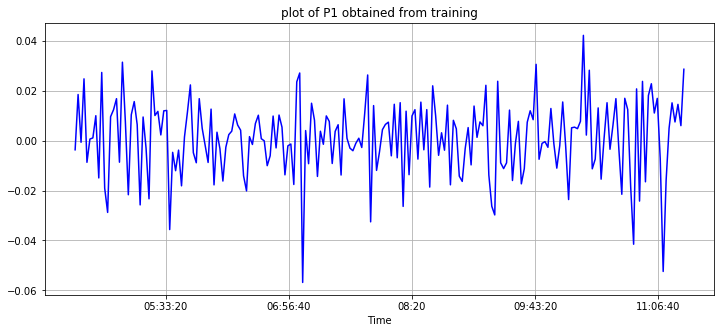

In [42]:
axes=train_data_2.P1.plot(color='blue',label='Actual SeriesA',grid=True,title="plot of P1 obtained from training",figsize=(12,5))

Şimdi de P1 serisinin 5 lik ve 10 luk Moving averagelarını bulalım ve hepsini bir arada görüntüleyelim:

In [44]:
train_data_2['P1MA5'] = train_data_2.iloc[:,4].rolling(window=5).mean()
train_data_2['P1MA10'] = train_data_2.iloc[:,4].rolling(window=10).mean()

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
train_data_2.head(10)

,SeriesA,SeriesB,SeriesC,SeriesD,P1,P1MA5,P1MA10
Time,,,,,,,
04:32:00,-0.002,-0.003,-0.001,0.004,-0.003624,NaN,NaN
04:34:00,0.018,0.013,0.004,0.010,0.018558,NaN,NaN
04:36:00,0.000,-0.002,0.000,-0.001,-0.000609,NaN,NaN
04:38:00,0.024,0.006,0.000,0.007,0.024847,NaN,NaN
04:40:00,-0.003,-0.002,0.006,0.004,-0.008644,0.006106,NaN
04:42:00,0.001,0.005,0.000,0.010,0.000686,0.006968,NaN
04:44:00,0.005,0.010,0.007,0.015,0.001148,0.003486,NaN
04:46:00,0.015,0.004,0.007,0.009,0.010057,0.005619,NaN
04:48:00,-0.013,-0.007,0.001,-0.007,-0.014909,-0.002332,NaN


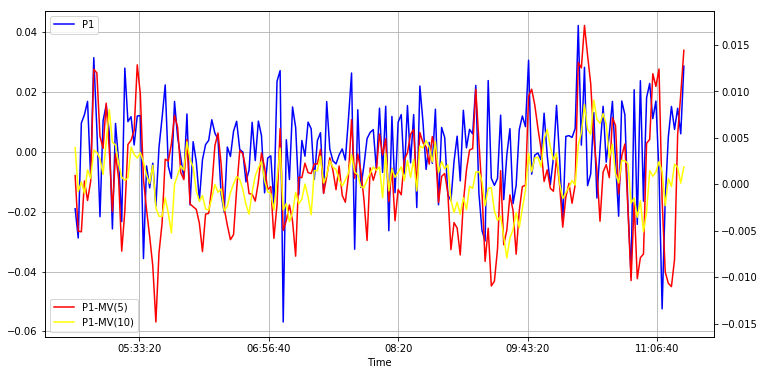

In [53]:
ax1=train_data_2.iloc[10:,4].plot(color='blue',label='P1',grid=True,figsize=(12,6))
ax2=train_data_2.iloc[10:,5].plot(color='red',label='P1-MV(5)',grid=True,secondary_y=True)
ax3=train_data_2.iloc[10:,6].plot(color='yellow',label='P1-MV(10)',grid=True,secondary_y=True)
ax1.legend(loc=2)
ax2.legend(loc=3)
ax3.legend(loc=3)

# VECM: P1, SeriesE, SeriesF, SeriesG

Öncelikle P1,Series5, Series6, Series 7 şeklinde bir veri yapımızı kuralım:

In [62]:
train_data_3=train_data_1[['SeriesE','SeriesF','SeriesG']]
train_data_3.insert(loc=0, column='P1', value=train_data_2['P1'])

In [63]:
train_data_3.head(10)

,P1,SeriesE,SeriesF,SeriesG
Time,,,,
04:32:00,-0.003624,0.012,0.008,-0.001
04:34:00,0.018558,0.018,0.054,0.001
04:36:00,-0.000609,0.005,-0.010,-0.005
04:38:00,0.024847,0.023,0.019,0.000
04:40:00,-0.008644,0.003,-0.023,0.005
04:42:00,0.000686,0.011,0.002,0.000
04:44:00,0.001148,0.035,-0.007,0.018
04:46:00,0.010057,0.005,0.025,-0.001
04:48:00,-0.014909,-0.005,0.000,-0.006


Artık VECM modelimizi kurabiliriz. Burada %95 güven aralığında 10 adet ileri tahmini yapacak modeli kuruyoruz

In [71]:
#VECM Modeli
#lag=4 linear trend within the cointegration relation
vecm = VECM(endog = train_data_3, k_ar_diff = 4, coint_rank = 3, deterministic = 'li')
vecm_fit = vecm.fit()
#model uzerinden 10 tahin noktası buluyoruz.(alt üst güven aralığı dahil)
forecast, lower, upper = vecm_fit.predict(10, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

lower bounds of confidence intervals:
[[-0.041 -0.024 -0.036 -0.008]
 [-0.034 -0.029 -0.03  -0.011]
 [-0.023 -0.024 -0.025 -0.011]
 [-0.027 -0.041 -0.028 -0.013]
 [-0.034 -0.04  -0.033 -0.013]
 [-0.025 -0.033 -0.026 -0.011]
 [-0.026 -0.038 -0.027 -0.012]
 [-0.026 -0.04  -0.028 -0.013]
 [-0.029 -0.043 -0.031 -0.013]
 [-0.028 -0.044 -0.029 -0.013]]

point forecasts:
[[-0.013  0.011 -0.008  0.004]
 [-0.006  0.006 -0.001  0.001]
 [ 0.006  0.013  0.005  0.002]
 [ 0.002 -0.001  0.002  0.   ]
 [-0.005  0.    -0.002 -0.   ]
 [ 0.005  0.011  0.006  0.003]
 [ 0.003  0.007  0.005  0.002]
 [ 0.004  0.007  0.004  0.002]
 [ 0.001  0.005  0.002  0.002]
 [ 0.002  0.006  0.003  0.002]]

upper bounds of confidence intervals:
[[0.014 0.045 0.021 0.016]
 [0.022 0.042 0.028 0.013]
 [0.034 0.05  0.034 0.014]
 [0.03  0.038 0.032 0.013]
 [0.024 0.041 0.028 0.013]
 [0.034 0.055 0.037 0.017]
 [0.033 0.052 0.037 0.016]
 [0.034 0.053 0.036 0.016]
 [0.031 0.053 0.034 0.016]
 [0.032 0.055 0.036 0.016]]


C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


tahmin modeline göre bakalım son train_data setinde P1 neymiş:

In [72]:
train_data_3.tail(1)

,P1,SeriesE,SeriesF,SeriesG
Time,,,,
11:24:00,0.028692,0.005,0.01,0.003


Son değer ile tahmin değerlerinin karşılaştırırsak görüyoru ki bir sonraki adımda güven aralıkları da dahil olmak üzere P1
serisi düşüşe girecek.